In [1]:
# ============================================================
# Standard library imports
# ============================================================
import itertools
from pathlib import Path

# ============================================================
# Numerical & data handling libraries
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# Plotting & visualization libraries
# ============================================================
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns

In [2]:
# Base directories for simulation data
BASE_DIR = Path("../simulation_data")
XQAOA_DIR = BASE_DIR / "XQAOA"


def _read_ints(path: Path):
    # Read whitespace-separated integers from a file
    return list(map(int, path.read_text().split()))


def get_xqaoa_cost(n, num_instances=50):
    # Collect and normalize all XQAOA costs across instances
    xqaoas = []
    for i in range(1, num_instances + 1):
        path = XQAOA_DIR / f"bpsp#{n}_{i}.txt"
        sim_data = _read_ints(path)
        xqaoas.extend(cost / n for cost in sim_data)
    return xqaoas


def get_rqaoa_cost(n):
    # Load and normalize RQAOA costs
    path = BASE_DIR / f"rqaoa_bpsp#{n}.txt"
    sim_data = _read_ints(path)
    return [cost / n for cost in sim_data]


def get_costs(n):
    # Convenience wrapper returning only RQAOA and XQAOA
    rqaoas = get_rqaoa_cost(n)
    xqaoas = get_xqaoa_cost(n)
    return rqaoas, xqaoas

In [3]:
# Load and organize RQAOA / XQAOA data for all problem sizes

N_VALUES = [128, 256, 512, 1024, 2048, 4096]

# Collect raw lists keyed by N
raw = {}
for n in N_VALUES:
    rqaoa, xqaoa = get_costs(n)
    raw[n] = {
        "rqaoa": rqaoa,
        "xqaoa": xqaoa,
    }

# Convert to DataFrames (columns = N)
rqaoas = pd.DataFrame({n: raw[n]["rqaoa"] for n in N_VALUES})
xqaoas = pd.DataFrame({n: raw[n]["xqaoa"] for n in N_VALUES})

# Melt for seaborn
rqaoas_melt = rqaoas.melt(var_name="# of Cars", value_name="Paint Swap Ratio")
xqaoas_melt = xqaoas.melt(var_name="# of Cars", value_name="Paint Swap Ratio")

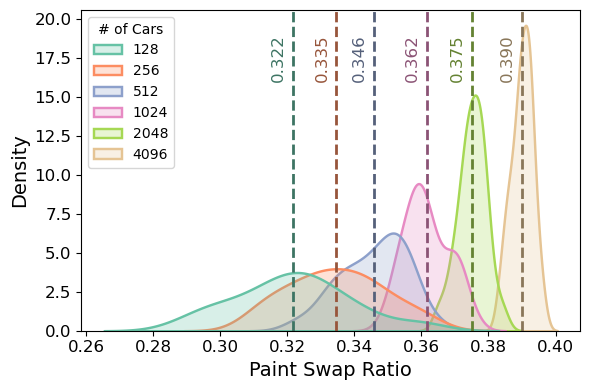

In [4]:
# KDE plot for RQAOA paint-swap ratios across N
set2 = sns.color_palette("Set2", 8)
palette = set2[:5] + [set2[6]]  # skip index 5 to keep a nicer 6-color set

fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(
    data=rqaoas_melt,
    x="Paint Swap Ratio",
    hue="# of Cars",
    fill=True,
    palette=palette,
    linewidth=1.75,
    ax=ax,
)

ax.set_xlabel("Paint Swap Ratio", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.tick_params(labelsize=12)

# Vertical reference lines (one per curve / N)
xvals = [0.321719, 0.334609, 0.345820, 0.361523, 0.375107, 0.389995]

def darken(rgb, f=0.6):
    return tuple(c * f for c in rgb)

# Place labels near the top of the plot area
y_text = ax.get_ylim()[1] * 0.85

for i, x in enumerate(xvals):
    line_col = darken(to_rgb(palette[i]), 0.6)
    ax.axvline(x, color=line_col, linestyle="--", linewidth=2)

    ax.text(
        x - 0.0065, y_text,
        f"{x:.3f}",
        rotation=90,
        ha="left", va="center",
        color=line_col,
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", pad=0, alpha=0.7),
    )

plt.tight_layout()
plt.savefig("rqaoa_kde.pdf", bbox_inches="tight")
plt.show()


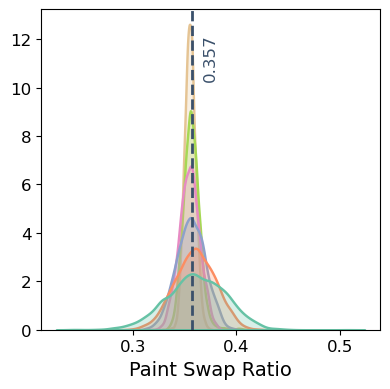

In [5]:
# KDE plot for XQAOA paint-swap ratios across N (no legend)

fig, ax = plt.subplots(figsize=(4, 4))

sns.kdeplot(
    data=xqaoas_melt,
    x="Paint Swap Ratio",
    hue="# of Cars",
    fill=True,
    palette=palette,
    linewidth=1.75,
    legend=False,
    ax=ax,
)

ax.set_xlabel("Paint Swap Ratio", fontsize=14)
ax.set_ylabel("")  # intentionally blank to match multi-panel layout
ax.tick_params(labelsize=12)

# Single vertical reference line + label
x_line = 0.357
line_color = "#3a506b"

ax.axvline(x_line, color=line_color, linestyle="--", linewidth=2)

y_text = ax.get_ylim()[1] * 0.85
ax.annotate(
    f"{x_line:.3f}",
    xy=(x_line, y_text),
    xytext=(8, 0),
    textcoords="offset points",
    rotation=90,
    ha="left", va="center",
    color=line_color,
    fontsize=12,
    bbox=dict(facecolor="white", edgecolor="none", pad=0, alpha=0.7),
)

plt.tight_layout()
plt.savefig("xqaoa_kde.pdf", bbox_inches="tight")
plt.show()